# MODFLOW-2005 + FloPy (v3.10.0) Tutorial: **BAS6** (Basic Package)

This notebook is dedicated to the **BAS6** package, which defines:
- which cells are **active / inactive / constant-head**
- the **starting head** values

> We’ll include minimal “supporting packages” (DIS, LPF, PCG, OC, and one stress like RCH) only so we can run a tiny demo model.

## Versions used for this tutorial

You said you’re using:
- **MODFLOW-2005**
- **FloPy 3.10.0**

Run this cell to confirm your environment versions.

In [1]:

import flopy
import sys
import platform
print("Python:", sys.version.split()[0], "|", platform.platform())
print("FloPy version:", getattr(flopy, "__version__", "unknown"))
print("Expected FloPy ~ 3.10.0 for this course workflow")

Python: 3.11.14 | Linux-6.8.0-1044-azure-x86_64-with-glibc2.41
FloPy version: 3.10.0
Expected FloPy ~ 3.10.0 for this course workflow


## BAS6 in one sentence

**BAS6 tells MODFLOW which cells exist (IBOUND) and what the starting/fixed heads are (STRT).**

## Learning goals

1. Interpret **IBOUND**:
   - `0` inactive (removed from the solution)
   - `>0` active (head is solved)
   - `<0` constant-head (head fixed to STRT; flux computed)

2. Build/plot `ibound` and `strt`.
3. Inspect the written `.bas` file (via `write_file()` + reading text back).
4. Run a minimal example to see constant-head boundaries behave as expected.

## BAS6: key inputs

### `ibound` (integer array)
- `0`: inactive (no head solved; removed from equations)
- `>0`: active (normal groundwater cell)
- `<0`: constant-head (head fixed to STRT; MODFLOW computes flux)

### `strt` (float array)
- active cells: initial condition / starting guess
- constant-head cells: the fixed boundary head value

### `hnoflo`
Value printed for inactive cells in outputs (does not change physics).

In [2]:

import os, shutil
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import flopy

In [3]:

# MODFLOW executable (edit if needed)
mf_exe = os.environ.get("MF2005_EXE", "mf2005")
exe_found = shutil.which(mf_exe) is not None or Path(mf_exe).exists()
print("MODFLOW executable:", mf_exe)
print("Executable found?  ", exe_found)

MODFLOW executable: mf2005
Executable found?   False


## 1) Build a tiny demo model

We’ll use a 1-layer 50×50 grid and set:
- left boundary = 100 m constant-head
- right boundary = 90 m constant-head
- interior = active

In [4]:

ws = Path("bas6_tutorial_ws")
ws.mkdir(exist_ok=True)

nlay, nrow, ncol = 1, 50, 50
dx, dy = 100.0, 100.0
top, botm = 100.0, 0.0

m = flopy.modflow.Modflow("bas6_demo", exe_name=mf_exe, model_ws=str(ws))

dis = flopy.modflow.ModflowDis(
    m, nlay=nlay, nrow=nrow, ncol=ncol,
    delr=dx, delc=dy, top=top, botm=botm,
    nper=1, perlen=[1.0], nstp=[1], tsmult=[1.0], steady=[True],
    itmuni=4, lenuni=2
)

/opt/conda/envs/hwrs564b/lib/python3.11/site-packages/flopy/mbase.py:105: UserWarning: The program mf2005 does not exist or is not executable.
  warn(


## 2) Create `ibound` and `strt`

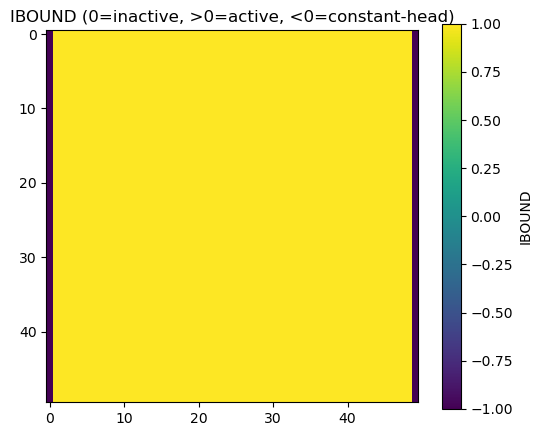

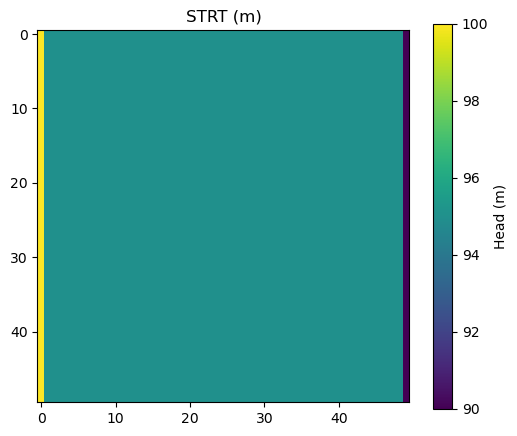

In [5]:

ibound = np.ones((nlay, nrow, ncol), dtype=int)
strt   = np.ones((nlay, nrow, ncol), dtype=float) * 95.0

# Constant-head columns
ibound[:, :, 0]  = -1
ibound[:, :, -1] = -1
strt[:, :, 0]  = 100.0
strt[:, :, -1] = 90.0

plt.figure(figsize=(6, 5))
plt.title("IBOUND (0=inactive, >0=active, <0=constant-head)")
plt.imshow(ibound[0])
plt.colorbar(label="IBOUND")
plt.show()

plt.figure(figsize=(6, 5))
plt.title("STRT (m)")
plt.imshow(strt[0])
plt.colorbar(label="Head (m)")
plt.show()

## 3) Create BAS6 and inspect the `.bas` text

FloPy 3.10.x does not reliably expose `get_file_entry()` for every package class,
so we write the file and read it back.

In [6]:

bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=strt, hnoflo=-999.99)

bas.write_file()
bas_path = Path(bas.parent.model_ws) / bas.file_name[0]
print("Wrote:", bas_path)
print(bas_path.read_text()[:1200])

Wrote: /workspaces/hwrs564b_course_materials_JessicaCarvalho007/Homework/zz_Practice_MODFLOW/bas6_tutorial_ws/bas6_demo.bas
# BAS6 package for MODFLOW-2005 generated by Flopy 3.10.0
FREE
INTERNAL               1    (50I10) -1 #ibound layer 1                
        -1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1        -1
        -1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1         1 

## 4) Optional: run a minimal steady model

We add LPF + RCH + PCG + OC just so we can solve heads and confirm the BAS6 setup.

In [7]:

hk = 10.0
lpf = flopy.modflow.ModflowLpf(m, hk=hk, vka=hk, ipakcb=53)
rch = flopy.modflow.ModflowRch(m, rech=1e-4)
pcg = flopy.modflow.ModflowPcg(m)
oc  = flopy.modflow.ModflowOc(m, stress_period_data={(0, 0): ["save head", "save budget"]}, compact=True)

m.write_input()

if exe_found:
    ok, buff = m.run_model(silent=True)
    print("Run success:", ok)
    if not ok:
        print("\n".join(buff[-30:]))
else:
    print("Executable not found; skipping run.")

Executable not found; skipping run.


In [8]:

if exe_found and (ws / "bas6_demo.hds").exists():
    head = flopy.utils.HeadFile(str(ws / "bas6_demo.hds")).get_data(kstpkper=(0, 0))

    import flopy.plot as fplt
    fig, ax = plt.subplots(figsize=(7, 6))
    pmv = fplt.PlotMapView(model=m, ax=ax, layer=0)
    im = pmv.plot_array(head)
    plt.colorbar(im, ax=ax, shrink=0.8, label="Head (m)")
    pmv.plot_ibound()
    ax.set_title("Solved heads (BAS6 constant-head boundaries)")
    plt.show()
else:
    print("No head file to plot (either skipped run or run failed).")

No head file to plot (either skipped run or run failed).


## 5) Exercises

1. Make a central inactive block (`ibound=0`) and re-run.
2. Change the boundary heads by editing `strt` in the constant-head columns.
3. Make only the **top row** constant head to simulate a boundary at y=0.